#### Installing and importing the required libraries

In [ ]:
!pip install transformers datasets sacrebleu rouge-score nltk
!pip install openai==0.28

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import openai
from tqdm import tqdm
from huggingface_hub import HfApi

#### Loading the evaluation metrics

In [ ]:
# Load metrics
metric_rouge = load_metric('rouge')
metric_bleu = load_metric('bleu')
metric_meteor = load_metric('meteor')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Loading both of the datasets

In [ ]:
bbcnews_data = pd.read_csv('bbcnews.csv')
cnn_dailymail_data = pd.read_csv('cnn_dailymail.csv')

# Split the datasets into training and testing sets (90% for training, 10% for testing)
bbcnews_train, bbcnews_test = train_test_split(bbcnews_data, test_size=0.1, random_state=42)
cnn_dailymail_train, cnn_dailymail_test = train_test_split(cnn_dailymail_data, test_size=0.05, random_state=42)

# Save the test sets for later evaluation
bbcnews_test.to_csv('bbcnews_test.csv', index=False)
cnn_dailymail_test.to_csv('cnn_dailymail_test.csv', index=False)

In [ ]:
# Load your test datasets (BBC and CNN/DailyMail)
bbcnews_testdata = pd.read_csv("bbcnews_test.csv")[:30]  # Taking only 30 instances for testing
cnndailymail_testdata = pd.read_csv("cnn_dailymail_test.csv")[:30]  # Taking only 30 instances for testing

In [ ]:
cnndailymail_testdata

,Unnamed: 0,source_text,target_text
0,243301,coxes rest comfortably living georgia year old...,georgia gov nathan deal signs medical marijuan...
1,98419,penalty shootout summed manchester united seas...,manchester united knocked out of english leagu...
2,212428,shocking footage fisherman beating shark head ...,shocking footage of man brutally beating shark...
3,113698,stewart published est september updated est se...,nadia tolokonnikova is on hunger strike over p...
4,14106,lizzie parry irish teenager coma suffering sus...,year old was injured when prank between classm...
5,248112,matt scott demanded scotland emotions check en...,it is years since scotland last won at twicken...
6,242854,stoke city opened talks possible summer deal e...,chelsea and liverpool target daniel wass can p...
7,89477,mail foreign service published est january upd...,the message was posted on pope benedict twitte...
8,23896,trio teenage boys caught snapping photos dangl...,three teenagers caught sitting on roof of auck...
9,61302,warning graphic content stunning photographs b...,franco banfi watched in awe as trio of polar b...


In [ ]:
bbcnews_testdata

,Unnamed: 0,source_text,target_text
0,1704,mobile bets pocket office mobile launched late...,mobile has launched its latest pocket office t...
1,1198,big guns ease san jose seeded americans andy r...,top seeded americans andy roddick and andre ag...
2,1461,wenger keeping faith almunia arsene wenger ple...,wenger said you do not think would take out on...
3,275,ore costs hit global steel firms shares steel ...,shares in germany thyssenkrupp the uk corus an...
4,416,ryanair bn boeing plane deal budget airline ry...,with this new order and new pricing in place r...
5,1034,tories unveil quango blitz plans plans abolish...,six government units would also be scrapped un...
6,247,mixed reaction man utd offer shares manchester...,manchester united revealed on sunday that it h...
7,383,uk coal plunges deeper loss shares uk coal fal...,uk coal said it was making significant progres...
8,322,krispy kreme shares hit shares krispy kreme do...,shares in krispy kreme doughnuts have taken du...
9,203,durex maker ssl awaits firm bid uk condom make...,uk condom maker ssl international has refused ...


#### Setting up my OpenAI API key

In [ ]:
openai.api_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

#### Importing all my fine-tuned transformer models from Hugging Face

In [ ]:
model_names = {
    "T5-BBC": "Damithewiz/fine-tuned-t5-bbcnews",
    "T5-CNN": "Damithewiz/fine-tuned-t5-cnn-dailymail",
    "BART-BBC": "Damithewiz/fine-tuned-bart-bbcnews",
    "BART-CNN": "Damithewiz/fine-tuned-bart-cnn-dailymail",
    "Pegasus-BBC": "Damithewiz/fine-tuned-pegasus-bbcnews",
    "Pegasus-CNN": "Damithewiz/fine-tuned-pegasus-cnn-dailymail"
}

#### Loading all my fine-tuned transformer models from Hugging Face

In [ ]:
# Load models and tokenizers
models = {name: AutoModelForSeq2SeqLM.from_pretrained(model_path) for name, model_path in model_names.items()}
tokenizers = {name: AutoTokenizer.from_pretrained(model_path) for name, model_path in model_names.items()}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Function to evaluate model predictions against references using various metrics


In [ ]:
def evaluate_model_on_dataset(model, tokenizer, dataset, dataset_name):
    results = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        inputs = row['source_text']
        target = row['target_text']

        # Generate summary
        inputs_tokenized = tokenizer(inputs, return_tensors="pt", max_length=512, truncation=True).input_ids
        summary_ids = model.generate(inputs_tokenized, max_length=150, min_length=40, length_penalty=2.0, num_beams=4)
        summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        # Calculate ROUGE
        rouge_result = metric_rouge.compute(predictions=[summary_text], references=[target])

        # Calculate BLEU
        target_tokens = [target.split()]
        summary_tokens = summary_text.split()
        bleu_result = metric_bleu.compute(predictions=[summary_tokens], references=[target_tokens])

        # Calculate METEOR
        meteor_result = metric_meteor.compute(predictions=[summary_text], references=[target])

        # Store results
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "ROUGE-1": rouge_result['rouge1'].mid.fmeasure,
            "ROUGE-2": rouge_result['rouge2'].mid.fmeasure,
            "ROUGE-L": rouge_result['rougeL'].mid.fmeasure,
            "BLEU": bleu_result['bleu'],
            "METEOR": meteor_result['meteor']
        })

    return pd.DataFrame(results)

#### Creating function to evaluate all the fine-tuned models

In [ ]:
# Fine-Tuned models on BBC News dataset
bbc_results = pd.DataFrame()
for model_name, model in models.items():
    if "BBC" in model_name:
        tokenizer = tokenizers[model_name]
        bbc_results = pd.concat([bbc_results, evaluate_model_on_dataset(model, tokenizer, bbcnews_testdata, "BBCNews")])

# Fine-Tuned models on CNN/DailyMail dataset
cnn_results = pd.DataFrame()
for model_name, model in models.items():
    if "CNN" in model_name:
        tokenizer = tokenizers[model_name]
        cnn_results = pd.concat([cnn_results, evaluate_model_on_dataset(model, tokenizer, cnndailymail_testdata, "CNN/DailyMail")])

100%|██████████| 30/30 [04:41<00:00,  9.38s/it]


In [ ]:
bbc_results

,Model,Dataset,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,METEOR
0,T5-BBC,BBCNews,0.420382,0.192308,0.229299,0.074153,0.245059
1,T5-BBC,BBCNews,0.397590,0.219512,0.289157,0.133269,0.287379
2,T5-BBC,BBCNews,0.324324,0.078550,0.144144,0.017829,0.148204
3,T5-BBC,BBCNews,0.413333,0.161074,0.293333,0.054930,0.222941
4,T5-BBC,BBCNews,0.450000,0.242424,0.370000,0.161838,0.319965
...,...,...,...,...,...,...,...
25,Pegasus-BBC,BBCNews,0.497561,0.275862,0.409756,0.187789,0.562162
26,Pegasus-BBC,BBCNews,0.563910,0.242424,0.278195,0.158653,0.375800
27,Pegasus-BBC,BBCNews,0.529617,0.245614,0.341463,0.203527,0.406888
28,Pegasus-BBC,BBCNews,0.548043,0.279570,0.412811,0.234165,0.434309


In [ ]:
cnn_results

,Model,Dataset,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,METEOR
0,T5-CNN,CNN/DailyMail,0.283019,0.134615,0.188679,0.046147,0.521178
1,T5-CNN,CNN/DailyMail,0.277228,0.040404,0.178218,0.000000,0.204517
2,T5-CNN,CNN/DailyMail,0.348624,0.130841,0.275229,0.000000,0.432363
3,T5-CNN,CNN/DailyMail,0.307692,0.078125,0.169231,0.000000,0.258268
4,T5-CNN,CNN/DailyMail,0.342342,0.091743,0.198198,0.000000,0.359482
...,...,...,...,...,...,...,...
25,Pegasus-CNN,CNN/DailyMail,0.122449,0.068966,0.108844,0.035716,0.198204
26,Pegasus-CNN,CNN/DailyMail,0.283019,0.096154,0.226415,0.084528,0.263377
27,Pegasus-CNN,CNN/DailyMail,0.320000,0.115607,0.228571,0.058552,0.375890
28,Pegasus-CNN,CNN/DailyMail,0.335766,0.148148,0.218978,0.060982,0.431843


#### GPT-3 Evaluation

In [ ]:
# GPT-3 Evaluation
def evaluate_gpt35_on_dataset(dataset, dataset_name):
    results = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        inputs = row['source_text']
        target = row['target_text']

        # GPT-3.5-turbo API call for summary generation
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-1106",
            messages=[
                {"role": "system", "content": "You are a text summarization model."},
                {"role": "user", "content": f"Summarize this article:\n{inputs}"}
            ],
            max_tokens=150
        )
        summary_text = response['choices'][0]['message']['content'].strip()

        # Evaluate the summary using ROUGE, BLEU, METEOR
        rouge_result = metric_rouge.compute(predictions=[summary_text], references=[target])
        bleu_result = metric_bleu.compute(predictions=[summary_text.split()], references=[[target.split()]])
        meteor_result = metric_meteor.compute(predictions=[summary_text], references=[target])

        # Store results
        results.append({
            "Model": "GPT-3.5-turbo",
            "Dataset": dataset_name,
            "ROUGE-1": rouge_result['rouge1'].mid.fmeasure,
            "ROUGE-2": rouge_result['rouge2'].mid.fmeasure,
            "ROUGE-L": rouge_result['rougeL'].mid.fmeasure,
            "BLEU": bleu_result['bleu'],
            "METEOR": meteor_result['meteor']
        })

    return pd.DataFrame(results)

# Evaluate GPT-3.5-turbo on both datasets
gpt35_bbc_results = evaluate_gpt35_on_dataset(bbcnews_testdata, "BBCNews")
gpt35_cnn_results = evaluate_gpt35_on_dataset(cnndailymail_testdata, "CNN/DailyMail")

100%|██████████| 30/30 [01:06<00:00,  2.21s/it]


In [ ]:
gpt35_bbc_results

,Model,Dataset,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,METEOR
0,GPT-3.5-turbo,BBCNews,0.312102,0.102564,0.178344,0.000000,0.122860
1,GPT-3.5-turbo,BBCNews,0.429907,0.207547,0.280374,0.000000,0.345603
2,GPT-3.5-turbo,BBCNews,0.304598,0.092486,0.143678,0.011172,0.135722
3,GPT-3.5-turbo,BBCNews,0.421384,0.132911,0.220126,0.028892,0.226622
4,GPT-3.5-turbo,BBCNews,0.405797,0.107317,0.193237,0.000000,0.273019
5,GPT-3.5-turbo,BBCNews,0.421053,0.168142,0.228070,0.068911,0.335833
6,GPT-3.5-turbo,BBCNews,0.371951,0.092025,0.176829,0.021393,0.211002
7,GPT-3.5-turbo,BBCNews,0.393258,0.125000,0.213483,0.045256,0.296054
8,GPT-3.5-turbo,BBCNews,0.378855,0.115556,0.246696,0.036658,0.276273
9,GPT-3.5-turbo,BBCNews,0.377358,0.191083,0.314465,0.055772,0.289950


In [ ]:
gpt35_cnn_results

,Model,Dataset,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,METEOR
0,GPT-3.5-turbo,CNN/DailyMail,0.149660,0.041379,0.095238,0.000000,0.282649
1,GPT-3.5-turbo,CNN/DailyMail,0.328125,0.079365,0.203125,0.000000,0.306321
2,GPT-3.5-turbo,CNN/DailyMail,0.287770,0.043796,0.172662,0.000000,0.364369
3,GPT-3.5-turbo,CNN/DailyMail,0.263158,0.040000,0.157895,0.000000,0.227030
4,GPT-3.5-turbo,CNN/DailyMail,0.364964,0.118519,0.204380,0.000000,0.312647
5,GPT-3.5-turbo,CNN/DailyMail,0.156522,0.035398,0.104348,0.000000,0.184462
6,GPT-3.5-turbo,CNN/DailyMail,0.305085,0.068966,0.152542,0.000000,0.214366
7,GPT-3.5-turbo,CNN/DailyMail,0.316547,0.145985,0.215827,0.062105,0.359802
8,GPT-3.5-turbo,CNN/DailyMail,0.396694,0.134454,0.314050,0.000000,0.426339
9,GPT-3.5-turbo,CNN/DailyMail,0.346667,0.108108,0.226667,0.000000,0.318666


#### Result Compilation

In [ ]:
# Combine all results
final_results = pd.concat([bbc_results, cnn_results, gpt35_bbc_results, gpt35_cnn_results])

# Display the final combined results
print(final_results)

            Model        Dataset   ROUGE-1   ROUGE-2   ROUGE-L      BLEU  \
0          T5-BBC        BBCNews  0.420382  0.192308  0.229299  0.074153   
1          T5-BBC        BBCNews  0.397590  0.219512  0.289157  0.133269   
2          T5-BBC        BBCNews  0.324324  0.078550  0.144144  0.017829   
3          T5-BBC        BBCNews  0.413333  0.161074  0.293333  0.054930   
4          T5-BBC        BBCNews  0.450000  0.242424  0.370000  0.161838   
..            ...            ...       ...       ...       ...       ...   
25  GPT-3.5-turbo  CNN/DailyMail  0.133333  0.036810  0.121212  0.000000   
26  GPT-3.5-turbo  CNN/DailyMail  0.295302  0.040816  0.147651  0.000000   
27  GPT-3.5-turbo  CNN/DailyMail  0.305085  0.080000  0.158192  0.000000   
28  GPT-3.5-turbo  CNN/DailyMail  0.240000  0.081081  0.173333  0.000000   
29  GPT-3.5-turbo  CNN/DailyMail  0.251748  0.042553  0.139860  0.000000   

      METEOR  
0   0.245059  
1   0.287379  
2   0.148204  
3   0.222941  
4   0.319965

In [ ]:
# Load the CSV file into a DataFrame
df = pd.read_csv('final_results.csv')

In [ ]:
df

,Model,Dataset,ROUGE-1,ROUGE-2,ROUGE-L,BLEU,METEOR
0,T5-BBC,BBCNews,0.420382,0.192308,0.229299,0.074153,0.245059
1,T5-BBC,BBCNews,0.397590,0.219512,0.289157,0.133269,0.287379
2,T5-BBC,BBCNews,0.324324,0.078550,0.144144,0.017829,0.148204
3,T5-BBC,BBCNews,0.413333,0.161074,0.293333,0.054930,0.222941
4,T5-BBC,BBCNews,0.450000,0.242424,0.370000,0.161838,0.319965
...,...,...,...,...,...,...,...
235,GPT-3.5-turbo,CNN/DailyMail,0.133333,0.036810,0.121212,0.000000,0.185327
236,GPT-3.5-turbo,CNN/DailyMail,0.295302,0.040816,0.147651,0.000000,0.250284
237,GPT-3.5-turbo,CNN/DailyMail,0.305085,0.080000,0.158192,0.000000,0.305915
238,GPT-3.5-turbo,CNN/DailyMail,0.240000,0.081081,0.173333,0.000000,0.243821


#### Tabular Representation of Results

In [ ]:
# Calculate the average metrics for each model on the BBC News dataset
bbcnews_avg = df[df['Dataset'] == 'BBCNews'].groupby('Model').agg({
    'ROUGE-1': 'mean',
    'ROUGE-2': 'mean',
    'ROUGE-L': 'mean',
    'BLEU': 'mean',
    'METEOR': 'mean'
}).reset_index()

# Display the resulting table
print(bbcnews_avg)

           Model   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0       BART-BBC  0.536744  0.289269  0.338763  0.198524  0.413218
1  GPT-3.5-turbo  0.404906  0.155117  0.233854  0.033501  0.276586
2    Pegasus-BBC  0.460630  0.220851  0.301229  0.155251  0.376120
3         T5-BBC  0.428754  0.212628  0.302874  0.135535  0.320835


In [ ]:
# Calculate the average metrics for each model on the CNN/Daily Mail dataset
cnndailymail_avg = df[df['Dataset'] == 'CNN/DailyMail'].groupby('Model').agg({
    'ROUGE-1': 'mean',
    'ROUGE-2': 'mean',
    'ROUGE-L': 'mean',
    'BLEU': 'mean',
    'METEOR': 'mean'
}).reset_index()

# Display the resulting table
print(cnndailymail_avg)

           Model   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0       BART-CNN  0.362294  0.130933  0.246944  0.047755  0.300226
1  GPT-3.5-turbo  0.279289  0.084990  0.180548  0.006250  0.300598
2    Pegasus-CNN  0.354192  0.136266  0.240549  0.060157  0.346835
3         T5-CNN  0.320570  0.123600  0.221617  0.049926  0.317515


#### Visual Representation of Results

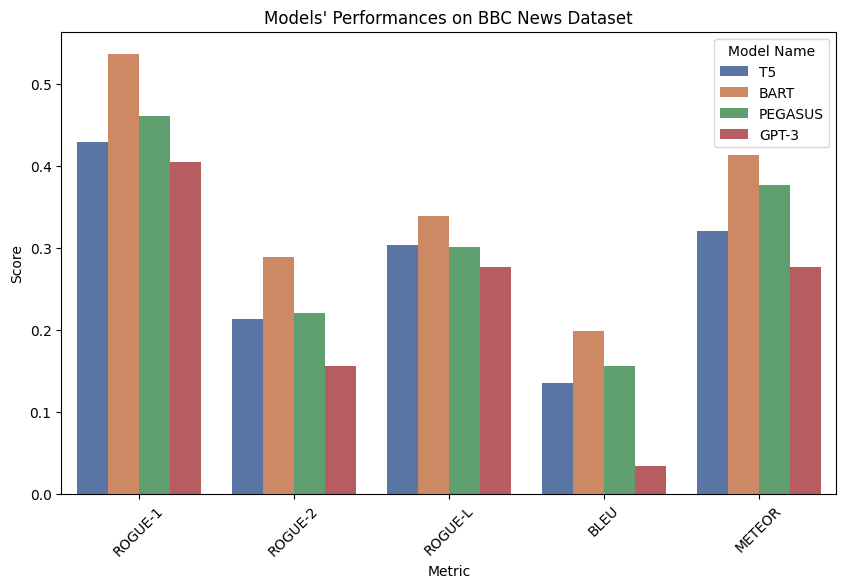

In [ ]:
# Data for BBC News Dataset
data_bbc = {
    'Model Name': ['T5', 'BART', 'PEGASUS', 'GPT-3'],
    'ROGUE-1': [0.428754, 0.536744, 0.460630, 0.404906],
    'ROGUE-2': [0.212628, 0.289269, 0.220851, 0.155117],
    'ROGUE-L': [0.302874, 0.338763, 0.301229, 0.276586],
    'BLEU': [0.135535, 0.198524, 0.155251, 0.033501],
    'METEOR': [0.320835, 0.413218, 0.376120, 0.276586]
}

df_bbc = pd.DataFrame(data_bbc)

# Melt the data for plotting
df_bbc_melted = df_bbc.melt(id_vars='Model Name', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model Name', data=df_bbc_melted, palette='deep')
plt.title('Models\' Performances on BBC News Dataset')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

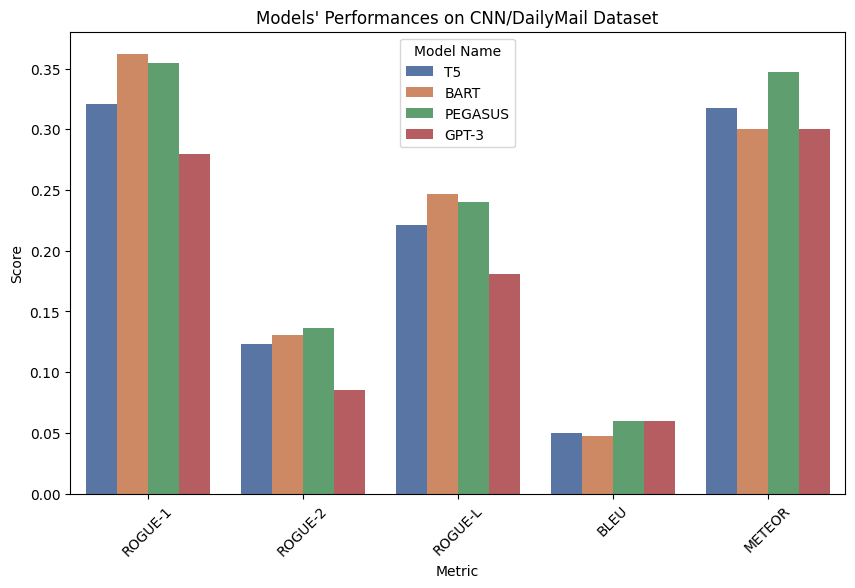

In [ ]:
# Data for CNN/DailyMail Dataset
data_cnn = {
    'Model Name': ['T5', 'BART', 'PEGASUS', 'GPT-3'],
    'ROGUE-1': [0.320570, 0.362294, 0.354192, 0.279289],
    'ROGUE-2': [0.123600, 0.130933, 0.136266, 0.084990],
    'ROGUE-L': [0.221617, 0.246944, 0.240549, 0.180548],
    'BLEU': [0.049926, 0.047755, 0.060157, 0.060157],
    'METEOR': [0.3177515, 0.300226, 0.346835, 0.300598]
}

df_cnn = pd.DataFrame(data_cnn)

# Melt the data for plotting
df_cnn_melted = df_cnn.melt(id_vars='Model Name', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model Name', data=df_cnn_melted, palette='deep')
plt.title('Models\' Performances on CNN/DailyMail Dataset')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

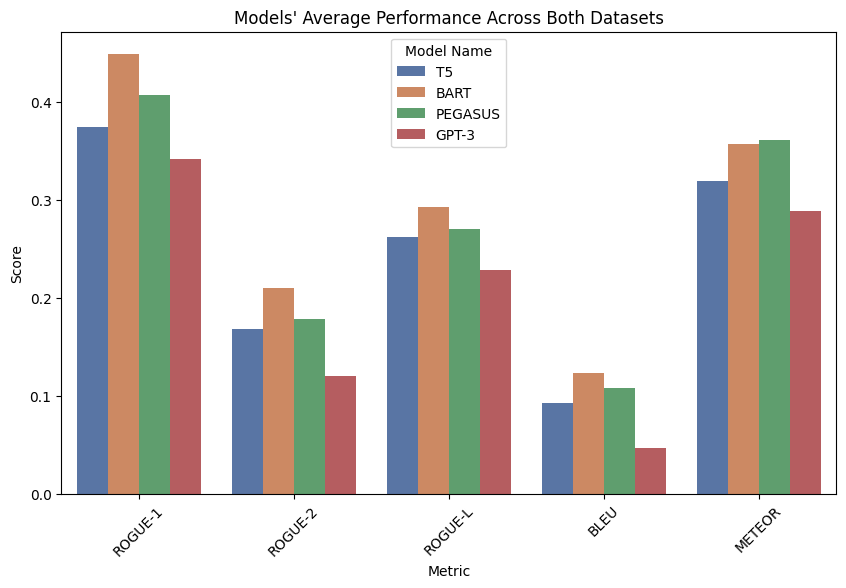

In [ ]:
# Data for Average Performance across both datasets
data_avg = {
    'Model Name': ['T5', 'BART', 'PEGASUS', 'GPT-3'],
    'ROGUE-1': [0.374662, 0.449519, 0.407411, 0.3420975],
    'ROGUE-2': [0.168114, 0.210101, 0.1785586, 0.1200535],
    'ROGUE-L': [0.2622455, 0.2928535, 0.270889, 0.228567],
    'BLEU': [0.0927305, 0.1231395, 0.107704, 0.046829],
    'METEOR': [0.31929325, 0.356722, 0.3614775, 0.288592]
}

df_avg = pd.DataFrame(data_avg)

# Melt the data for plotting
df_avg_melted = df_avg.melt(id_vars='Model Name', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model Name', data=df_avg_melted, palette='deep')
plt.title('Models\' Average Performance Across Both Datasets')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()